In [1]:
from osgeo import gdal
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from gis_tools import delineate_sub_basin
import geopandas as gpd
import csv
import os
import numpy as np
from scipy.ndimage import binary_fill_holes
from numba import jit
import geopandas as gpd
from osgeo import gdal



In [2]:
fa_file = r'../HydroSHEDS/hyd_af_acc_30s/hyd_af_acc_30s_ext.tif'
Q_stations = r'../self/discharge_stations.geojson' 

In [3]:
gdf_stations = gpd.read_file(Q_stations, index_col=[0])

In [4]:
gdf_stations = gdf_stations[gdf_stations.stations == '1159110_Q_Day.Cmd.txt']

In [5]:


def delineate_sub_basin(flow_accumulation_grid, x, y, fill_holes=True, kernel_size=3):
    """
    Function that delineates a sub basin from a flow accumulation and a starting point.
    flow_accumulation_grid: 2d numpy array of flow accumulation
    x: x starting point
    y: y starting point
    """
    
    @jit(nopython=True)
    def sub_basin_algo(x, y, flow_accumulation_grid, x_coords, y_coords, sub_basin_grid, kernel_size):

        ic = 0
        jc = 0
        
        while True:
            y = y_coords[ic]
            x = x_coords[ic]

            # get value of coordinates
            fa_val = flow_accumulation_grid[y,x]

            # iterate over window to make new coordinates
            for i in range(-kernel_size//2,kernel_size//2+1,1):
                y_n = y + i

                for j in range(-kernel_size//2,kernel_size//2+1,1):
                    x_n = x + j

                    # check if flow accumulation value of window is higher than original
                    if not sub_basin_grid[y_n, x_n]:

                        fa_val_new = flow_accumulation_grid[y_n, x_n]
                        if fa_val_new < fa_val:
                            jc += 1
                            sub_basin_grid[y_n, x_n] = True
                            y_coords[jc] = y_n
                            x_coords[jc] = x_n

            # increment counter
            ic+=1
            if ic > jc:
                break
                
        return sub_basin_grid
    
    # make x and y coordinate array
    x_coords = np.zeros(flow_accumulation_grid.shape[0] * flow_accumulation_grid.shape[1], dtype=int)
    y_coords = np.zeros_like(x_coords, dtype=int)
    x_coords[0] = x
    y_coords[0] = y
    
    # make sub-basin grid
    sub_basin_grid = np.full(flow_accumulation_grid.shape, False, dtype=bool)
    sub_basin_grid[y, x] = True
    
    # compute sub_basin_grid
    sub_basin_grid = sub_basin_algo(x, y, flow_accumulation_grid, x_coords, y_coords, sub_basin_grid, kernel_size)
    
    # fill holes in sub_basin_grid
    if fill_holes:
        sub_basin_grid = binary_fill_holes(sub_basin_grid)
    
    return sub_basin_grid


def sub_basins_per_station(path_to_flow_accumulation, gdf_stations, kernel_size=3):
    """
    Function that creates a binary numpy tensor with sub-catchments, starting at each station
    path_to_flow_accumulation: path to flow accumulation file
    gdf_stations: GeoDataFrame with stations
    """

    # open gdal file
    fa_gd = gdal.Open(path_to_flow_accumulation)
    flow_accumulation_grid = fa_gd.ReadAsArray()

    # open coordinates
    top_left_lon, w_e_px_res, _, top_left_lat, _, n_s_px_res = fa_gd.GetGeoTransform()

    # make 3d data block that fits all the basin arrays:
    all_sub_basins_block = np.full((len(gdf_stations), flow_accumulation_grid.shape[0], flow_accumulation_grid.shape[1]), False, dtype=bool)

    # iterate over stations
    for i, (_,row) in enumerate(gdf_stations.iterrows()):
        
        # get lat and lon of stations
        lat = row.lats
        lon = row.lons
        
        # get x and y offsets of start point
        x = int(np.floor((lon - top_left_lon)/w_e_px_res))
        y = int(np.floor((lat - top_left_lat)/n_s_px_res))

        # obtain delineation
        sub_basin_grid = delineate_sub_basin(flow_accumulation_grid, x, y, kernel_size=kernel_size)
        all_sub_basins_block[i] = sub_basin_grid
    
    return all_sub_basins_block


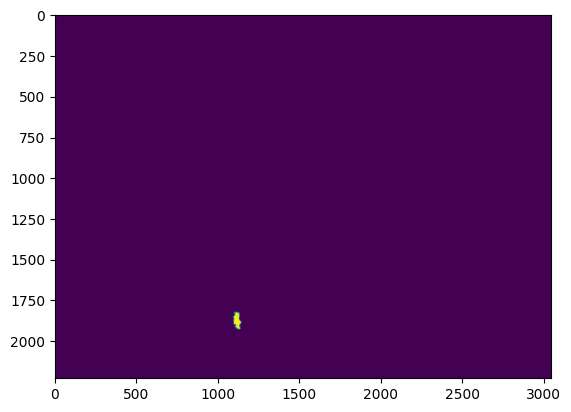

In [8]:
arr = sub_basins_per_station(fa_file, gdf_stations, kernel_size=5)
plt.imshow(arr[0])

<AxesSubplot: >

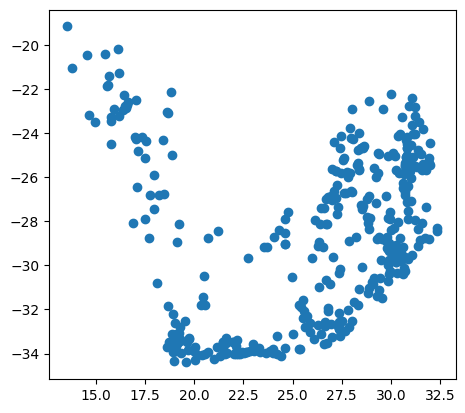

In [10]:
gdf_stations.plot()

In [11]:
gdf_stations[gdf_stations['stations']=='1255100_Q_Day.Cmd.txt']

,field_1,stations,lats,lons,start,end,geometry
